In [1]:
using LinearAlgebra
using ForwardDiff
using SatelliteDynamics
using DifferentialEquations
using Plots
using ECOS, Convex
using Mosek, MosekTools

ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.


In [2]:
#From slide deck

#values are in km and degrees 

#orbits elements of und roads 1
#last is the true anomaly 
elements1 = [6885.635e3, 0.001089, 97.43, 0, 0, 0]


#orbital elements of und roads 2
#last is the true anomaly
elements2 = [6885.635e3, 0.001089, 97.43, 0, 0, 0.016667]

6-element Vector{Float64}:
  6.885635e6
  0.001089
 97.43
  0.0
  0.0
  0.016667

In [3]:
#convert the true anomaly to mean anomaly to be able to do the conversion and degrees to radians

In [4]:
function degrees_to_rad(x)

    return x*pi/180
    
end

degrees_to_rad (generic function with 1 method)

In [5]:
#v is true anomaly 
#e is the eccentricity
function true_anom_to_eccentric_anom(v, e)

    E = 2*atand(sqrt((1-e)/(1+e))*tand(v/2))

    #eccentric anomaly
    return E

end

true_anom_to_eccentric_anom (generic function with 1 method)

In [6]:
function eccentric_anom_to_mean_anom(E, e)

    M = E - e*sind(E)

    #mean anomaly
    return M

end

eccentric_anom_to_mean_anom (generic function with 1 method)

In [7]:
#eccentric anomaly sat 1
E1 = true_anom_to_eccentric_anom(elements1[end], elements1[2])

#mean anomaly sat 1
M1 = eccentric_anom_to_mean_anom(E1, elements1[2])

0.0

In [8]:
#eccentric anomaly sat 2
E2 = true_anom_to_eccentric_anom(elements2[end], elements2[2])

#eccentric anomaly sat 2
M2  = eccentric_anom_to_mean_anom(E2, elements2[2])

0.016648543070573774

In [9]:
#get all the units consistent (m, radians)
#need to change the inclanation to radians, the rest are zeros

elements1_m = [elements1[1:2]; degrees_to_rad(elements1[3]); elements1[4:5]; degrees_to_rad(M1)]

elements2_m = [elements2[1:2]; degrees_to_rad(elements2[3]); elements2[4:5]; degrees_to_rad(M2)]

6-element Vector{Float64}:
 6.885635e6
 0.001089
 1.7004742902180754
 0.0
 0.0
 0.00029057189224159907

In [10]:
#state satellite 1 (target)

x_1 = sOSCtoCART(elements1_m, use_degrees=false)

6-element Vector{Float64}:
    6.878136543485e6
    0.0
    0.0
    0.0
 -984.9589353739226
 7552.79897887146

In [11]:
#state satellite 2 (chaser)

x_2 = sOSCtoCART(elements2_m, use_degrees=false)

6-element Vector{Float64}:
    6.878136252166805e6
 -259.0113696278884
 1986.134383662354
   -2.2156282462577286
 -984.9588936567426
 7552.798658978454

In [12]:
#relative state of chaser wrt target
#this is in ECI frame
difference = x_2 - x_1 

6-element Vector{Float64}:
   -0.2913181949406862
 -259.0113696278884
 1986.134383662354
   -2.2156282462577286
    4.171718001089175e-5
   -0.0003198930062353611

In [13]:
#this is in the LVLH (RTN) frame of the target (primary observing satellite) 
initial_difference = sECItoRTN(x_1, x_2) 

6-element StaticArraysCore.SVector{6, Float64} with indices SOneTo(6):
   -0.2913181949406862
 2002.9519913273894
    2.7017514072632172e-14
    0.002412819262479271
   -1.5962127995240716e-12
    3.511794450825904e-14

In [14]:
position_scale = norm(x_1[1:3])

6.878136543485e6

In [15]:
#bake in the scaling into the B matrix
#have 4.66 mm/s2 be equal to 1 distance_unit/time_unit

In [16]:
#u is scaled to 1

In [17]:
#first attempt is by only scaling time
tu = sqrt(4.66e-3)

0.06826419266350404

In [18]:
#scale the distance by the l2 norm of the target

#scale the time by the period of the target

In [19]:
# velocity_scale = 1/tu
# acceleration_scale = 1/(tu)^2

In [20]:
#this is what goes in the B matrix (not working)
#1/acceleration_scale

In [21]:
#to get it to equal 1 you multiply

In [22]:
#mu - gravitational parameter (m3/s2)
mu = 3.986e14

3.986e14

In [23]:
#radius of Earth (m)
r_e = 6.371e6

6.371e6

In [24]:
#sma from ppt (m)
a = 6.85635e6

6.85635e6

In [25]:
#constant mean motion of target n = sqrt(mu/a^3)
#units: rad/s
n = sqrt(mu/a^3)

0.0011120624547982091

In [26]:
#number of states
nx = 6

#number of control inputs
nu = 3

3

In [27]:
#this is a whole orbit for dt=60
N = 94

#this is a whole orbit for dt=1
#N = 5650

94

In [28]:
#target orbit period in seconds

#this a is of the target orbit 

T = 2*pi*sqrt((a^3)/(mu))

5650.029168838104

In [29]:
#time scale
time_scale = T

5650.029168838104

In [30]:
velocity_scale = position_scale/time_scale 

acceleration_scale = position_scale/(time_scale^2)

0.2154613681741382

In [31]:
n_scaled = n/time_scale 

1.9682419710886172e-7

In [32]:
#update code to use the scaled units!

In [33]:
#timestep 
#works better with 1 second...
#dt = 1

#trying out
dt = 60

60

In [34]:
dt_scaled = 1/time_scale 

0.00017699023670804238

In [35]:
thist = LinRange(1, N*dt, N)

94-element LinRange{Float64, Int64}:
 1.0, 61.6344, 122.269, 182.903, 243.538, …, 5458.1, 5518.73, 5579.37, 5640.0

In [36]:
x0_target = zeros(nx) 

6-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [37]:
#using the true data from the ppt
#relative state of the chaser wrt target 
#in the target RTN frame
x0_chaser = initial_difference

6-element StaticArraysCore.SVector{6, Float64} with indices SOneTo(6):
   -0.2913181949406862
 2002.9519913273894
    2.7017514072632172e-14
    0.002412819262479271
   -1.5962127995240716e-12
    3.511794450825904e-14

In [38]:
x0_chaser_scaled = [x0_chaser[1:3]/position_scale; x0_chaser[4:6]/velocity_scale] 

6-element Vector{Float64}:
 -4.235423258885781e-8
  0.0002912056163270841
  3.928028166033324e-21
  1.9820047371777003e-6
 -1.3112052690384923e-15
  2.884755334048192e-17

In [39]:
A = zeros(nx, nx)
A[1:3, 4:6] = I(3)
A[4, 1] = 3*n^2
A[6, 3] = -n^2
A[4, 5] = 2*n
A[5, 4] = -2*n

-0.0022241249095964182

In [40]:
A_scaled = zeros(nx, nx)
A_scaled[1:3, 4:6] = I(3)
A_scaled[4, 1] = 3*n_scaled^2
A_scaled[6, 3] = -n_scaled^2
A_scaled[4, 5] = 2*n_scaled
A_scaled[5, 4] = -2*n_scaled

-3.9364839421772345e-7

In [41]:
#mass of the satellite (kg) from data
m = 5.22

5.22

In [42]:
#si units
B = [zeros(3,3); I(3)]

#scaled
#B = [zeros(3,3); 1/acceleration_scale*I(3)]

#trying new
#this maps an l1 norm of 1 to 4.66e-3 (bug, not working)

#B = [zeros(3,3); 1/acceleration_scale*I(3)]

6×3 Matrix{Float64}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 1.0  0.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0

In [43]:
#continous dynamics
function spacecraft_dynamics(x,u)

    xdot = A*x + B*u

    return xdot

end

spacecraft_dynamics (generic function with 1 method)

In [44]:
#discretize the dynamics model 
H_scaled = exp(dt_scaled*[A_scaled B; zeros(nu, nx+nu)])

9×9 Matrix{Float64}:
  1.0          0.0   0.0           0.00017699   …  3.63752e-19  0.0
 -4.2275e-32   1.0   0.0          -6.16563e-15     1.56628e-8   0.0
  0.0          0.0   1.0           0.0             0.0          1.56628e-8
  2.05697e-17  0.0   0.0           1.0             6.16563e-15  0.0
 -7.16565e-28  0.0   0.0          -6.96719e-11     0.00017699   0.0
  0.0          0.0  -6.85656e-18   0.0          …  0.0          0.00017699
  0.0          0.0   0.0           0.0             0.0          0.0
  0.0          0.0   0.0           0.0             1.0          0.0
  0.0          0.0   0.0           0.0             0.0          1.0

In [45]:
#Scaled Discrete Dynamics Matrices
Ad_scaled  = H_scaled[1:nx, 1:nx]
Bd_scaled = H_scaled[1:nx, (nx+1):end]

6×3 Matrix{Float64}:
  1.56628e-8   3.63752e-19  0.0
 -3.63752e-19  1.56628e-8   0.0
  0.0          0.0          1.56628e-8
  0.00017699   6.16563e-15  0.0
 -6.16563e-15  0.00017699   0.0
  0.0          0.0          0.00017699

In [46]:
#discretize the dynamics model 
H = exp(dt*[A B; zeros(nu, nx+nu)])

9×9 Matrix{Float64}:
  1.00668      0.0   0.0         …  1799.33       80.0507      0.0
 -0.000296992  1.0   0.0             -80.0507   1797.33        0.0
  0.0          0.0   0.997775          0.0         0.0      1799.33
  0.000222438  0.0   0.0              59.9555      4.00194     0.0
 -1.48474e-5   0.0   0.0              -4.00194    59.822       0.0
  0.0          0.0  -7.41459e-5  …     0.0         0.0        59.9555
  0.0          0.0   0.0               1.0         0.0         0.0
  0.0          0.0   0.0               0.0         1.0         0.0
  0.0          0.0   0.0               0.0         0.0         1.0

In [47]:
#Discrete Dynamics Matrices
Ad  = H[1:nx, 1:nx]
Bd = H[1:nx, (nx+1):end]

6×3 Matrix{Float64}:
 1799.33       80.0507      0.0
  -80.0507   1797.33        0.0
    0.0         0.0      1799.33
   59.9555      4.00194     0.0
   -4.00194    59.822       0.0
    0.0         0.0        59.9555

In [48]:
Ad_scaled 

6×6 Matrix{Float64}:
  1.0          0.0   0.0           0.00017699   6.16563e-15  0.0
 -4.2275e-32   1.0   0.0          -6.16563e-15  0.00017699   0.0
  0.0          0.0   1.0           0.0          0.0          0.00017699
  2.05697e-17  0.0   0.0           1.0          6.96719e-11  0.0
 -7.16565e-28  0.0   0.0          -6.96719e-11  1.0          0.0
  0.0          0.0  -6.85656e-18   0.0          0.0          1.0

In [49]:
#discrete dynamics
function spacecraft_dynamics_discrete(x,u)

    xnext = Ad*x + Bd*u

    return xnext

end

spacecraft_dynamics_discrete (generic function with 1 method)

In [50]:
acceleration_scale 

0.2154613681741382

In [51]:
4.66e-3/acceleration_scale 

0.0216280070970019

In [52]:
#both of these horizons are 1 orbit...

#when dt is a minute
#N_h = 94

#when dt is a second
#N_h = 5650


N_h = N

94

In [53]:
x_initial = x0_chaser

6-element StaticArraysCore.SVector{6, Float64} with indices SOneTo(6):
   -0.2913181949406862
 2002.9519913273894
    2.7017514072632172e-14
    0.002412819262479271
   -1.5962127995240716e-12
    3.511794450825904e-14

In [54]:
x_goal = x0_target

6-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [55]:
test_og = Ad*x0_chaser

6-element Vector{Float64}:
   -0.14860116219705305
 2002.9424218890772
    2.132470941681533e-12
    0.002342650074188926
   -0.0003174205091450142
    3.5037796697226343e-14

In [56]:
test = Ad_scaled*x0_chaser_scaled  

6-element Vector{Float64}:
 -4.200343710126827e-8
  0.0002912056163270839
  9.033763460213099e-21
  1.9820047371777003e-6
 -1.449295349426939e-15
  2.884755334048192e-17

In [57]:
function update_prob(x_initial_k)


    X = Convex.Variable(nx, N_h)
    U = Convex.Variable(nu, N_h-1)

    #slack variables 
    #representing the L2 norm control constraint
    t = Convex.Variable(nu, N_h-1)

    #for the L2 position cost 
    s = Convex.Variable(nx, N_h)
    

    #Initial State Constraint
    cons = Constraint[X[:,1] == x_initial_k]

    #Dynamics Constraint
    for k=1:(N_h-1)

        push!(cons, X[:,k+1] - (Ad*X[:,k] + Bd*U[:,k]) == zeros(6))

    end


    #try both l1 and l2
    for k=1:(N_h-1)

    #    #this thrust is small
    #    #trying to increase it by an order of magnitude 

       #L1 works
       push!(cons, norm(U[:,k],1) <= t)

    end

    #upper bound for the slack
    for k=1:(N_h-1)
        #4.6e-3 is tmax
        push!(cons, t[k] < 4.6e-3)

    end


    #slack is the upper bound for the L2 norm cost on position
    for k=1:N_h

        push!(cons, norm(X[k],2) <= s)

    end
        


    #need to implement in a way tiny mpc can do it...
    # for k=1:(N_h-1)

    #     if (k%2) == 0

    #         push!(cons, U[:,k] == zeros(3))

    #     else
    #         continue
    #     end


    # end

    return cons, X, U, t, s

end

update_prob (generic function with 1 method)

In [59]:
function solve_prob(cons, X, U, t, s, N)


    #objective 
    obj = 0

    #weights depending how conservative you want to be on fuel vs reaching the goal
    beta = 100
    alpha = 1

    # for k=1:N-1
    #     obj += beta*norm(U[:,k], 1) + alpha*norm(X[:,k], 2)
    # end

    # #terminal cost
    # obj += alpha*norm(X[:,N], 2)


    #cost function wrt slack variables
    for k=1:N-1
        obj += beta*t[k] + alpha*s[k]
    end

    #terminal cost
    obj += alpha*s[N]



    prob = minimize(obj, cons)

    #solve with ECOS
    Convex.solve!(prob, ()-> ECOS.Optimizer(), silent_solver=true);

    #Convex.solve!(prob, ()-> Mosek.Optimizer(), silent_solver = true)

    Xm = X.value
    Um = U.value

    return Xm, Um

end

solve_prob (generic function with 1 method)

In [60]:
#iterations = 1000
num_orbits = 2

#50 orbits worth of data
iterations = N*num_orbits

188

In [61]:
#set up in Convex.jl

In [62]:
xhist = zeros(nx, iterations)
uhist = zeros(nu, iterations-1)

xhist[:,1] = x_initial

6-element StaticArraysCore.SVector{6, Float64} with indices SOneTo(6):
   -0.2913181949406862
 2002.9519913273894
    2.7017514072632172e-14
    0.002412819262479271
   -1.5962127995240716e-12
    3.511794450825904e-14

In [63]:
iterations 

188

In [64]:
iters_odd = 1:2:iterations-2

1:2:185

In [66]:
for i=1:iterations-1

# for i in iters_odd
    
    cons, X, U, t, s = update_prob(xhist[:,i])

    Xm, Um = solve_prob(cons, X, U, t, s, N_h)

    #take one step 
    uhist[:,i] = Um[:,1]

    xhist[:,i+1] = spacecraft_dynamics_discrete(xhist[:,i], uhist[:,i])



end

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Conv

In [67]:
all_norms = zeros(iterations-1)

for i=1:iterations-1

    all_norms[i] = norm(uhist[:,i],1)

end

In [68]:
uhist 

3×187 Matrix{Float64}:
 -4.42556e-6   -4.28258e-6   -4.18195e-6   …   0.00217014    0.00231637
  4.56276e-6    4.8824e-6     3.66025e-6      -0.000902668  -0.000808916
 -6.63274e-24  -4.34575e-24   1.33026e-24      2.02566e-24   2.89615e-24

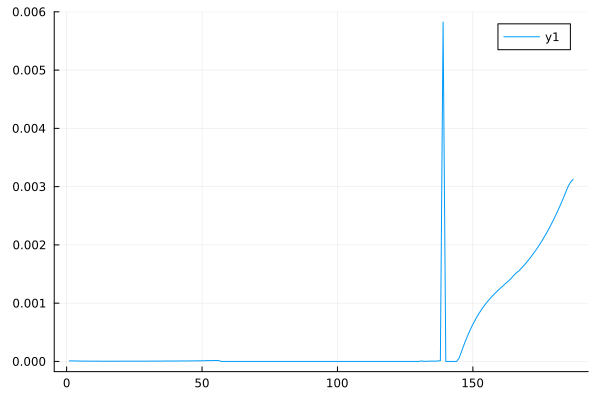

In [69]:
#does full on norm for all the iterations...
plot(all_norms) 
#plot!(4.6e-3*ones(iterations))

In [70]:
all_norms 


187-element Vector{Float64}:
 8.98831923870109e-6
 9.164984130401638e-6
 7.84219470462896e-6
 6.877383506950376e-6
 6.727034264934335e-6
 5.202750541160851e-6
 5.747220842489069e-6
 5.092885069778251e-6
 4.613145326729615e-6
 4.697323133186367e-6
 ⋮
 0.0023597955113247512
 0.0024523613262727724
 0.002549474282206289
 0.00265128659856326
 0.002757914135090444
 0.0028694695229170794
 0.002986165953155263
 0.0030728034293380463
 0.0031252823818747584

In [71]:
xhist 

6×188 Matrix{Float64}:
   -0.291318       -0.156199     …  -648.099        -673.942
 2002.95         2002.95            1609.7          1608.04
    2.70175e-14     2.13247e-12       -4.87204e-12    -2.78096e-12
    0.00241282      0.00209557        -0.42517        -0.437009
   -1.59621e-12    -2.67566e-5        -0.0319822      -0.0230401
    3.51179e-14     3.50378e-14  …     3.46964e-14     3.49804e-14

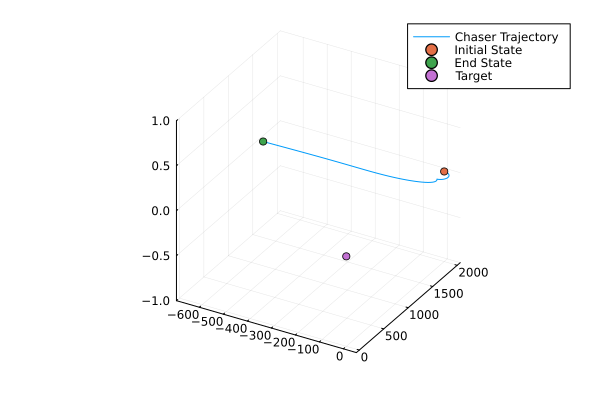

In [72]:
plot(xhist[1,:], xhist[2,:], xhist[3,:], label = "Chaser Trajectory", zlim = (-1,1))

scatter!([xhist[1,1]], [xhist[2,1]], [xhist[3,1]], label = "Initial State")
scatter!([xhist[1,end]], [xhist[2,end]], [xhist[3,end]], label = "End State")

scatter!([0], [0], [0], label= "Target")

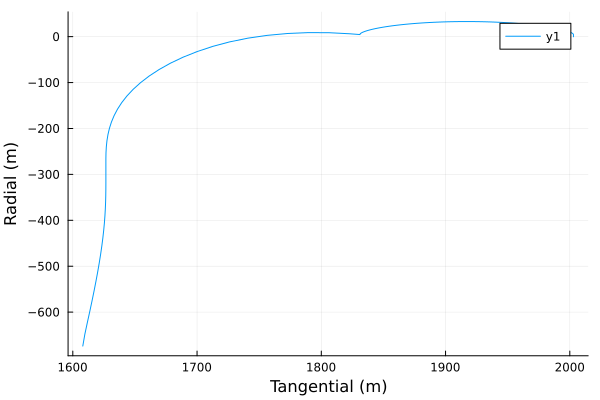

In [73]:
plot(xhist[2,:], xhist[1,:], xlabel= "Tangential (m)", ylabel="Radial (m)")

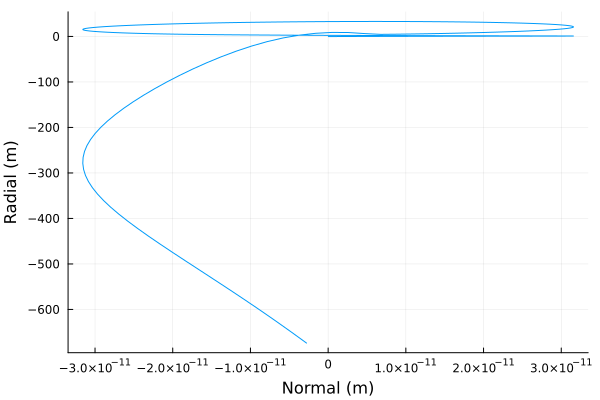

In [74]:
plot(xhist[3,:], xhist[1,:], xlabel= "Normal (m)", ylabel="Radial (m)", label=false)

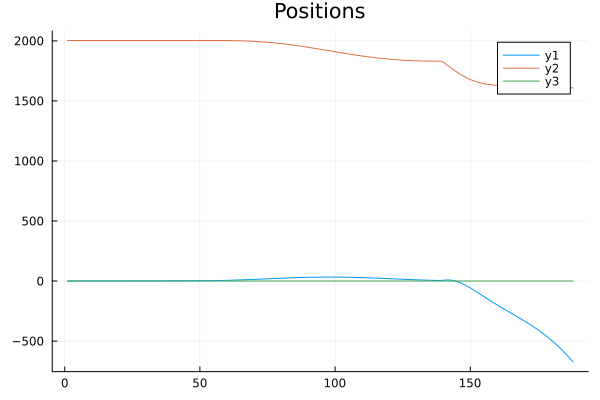

In [75]:
plot(xhist[1,:], title="Positions") 
plot!(xhist[2,:])
plot!(xhist[3,:])

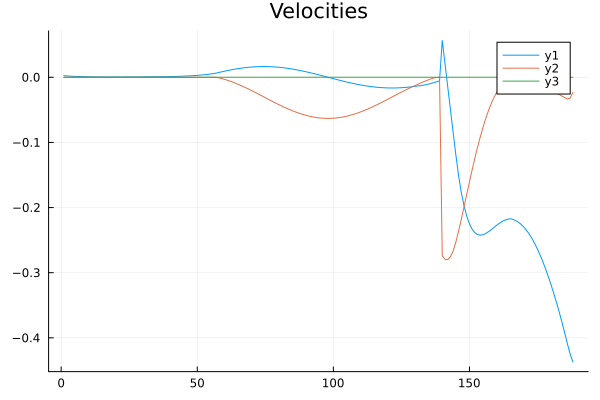

In [76]:
plot(xhist[4,:], title="Velocities") 
plot!(xhist[5,:])
plot!(xhist[6,:])

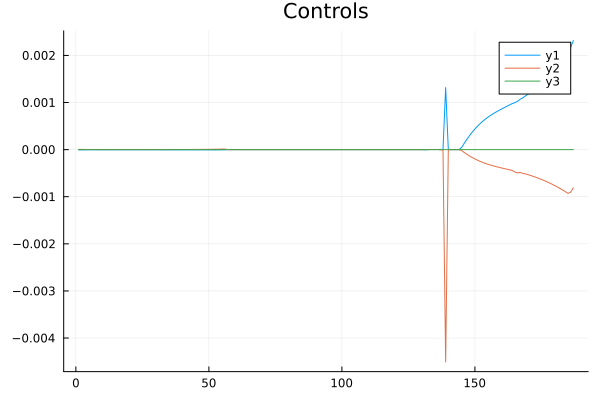

In [77]:
plot(uhist[1,:], title = "Controls")
plot!(uhist[2,:])
plot!(uhist[3,:])

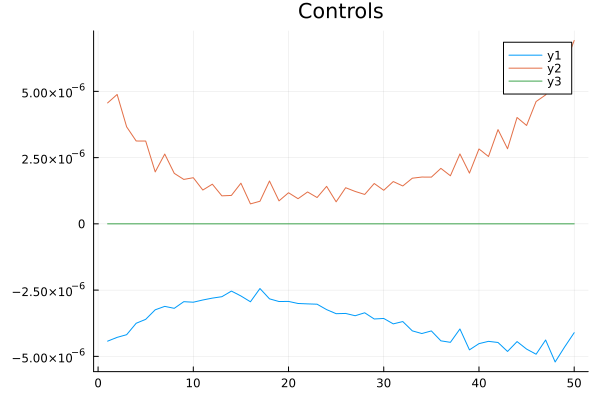

In [78]:
plot(uhist[1,1:50], title = "Controls")
plot!(uhist[2,1:50])
plot!(uhist[3,1:50])

In [ ]:
fuel_usage = sum(abs.(vec(uhist)))

In [ ]:
dt*fuel_usage 

In [ ]:
no_control = zeros(nx, iterations)

In [ ]:
no_control[:,1] = x0_chaser

In [ ]:
for i = 1:iterations-1

    no_control[:, i+1] = Ad*no_control[:,i]

end

In [ ]:
# plot(no_control[1,:], no_control[2,:], no_control[3,:], zlims=(-1,1))
# scatter!([0], [0], [0])

In [ ]:
plot(no_control[2,:], no_control[1,:])

In [ ]:
plot(no_control[3,:], no_control[1,:])